# PUBG 생존자 예측 모델링

## 데이터 설명

File descriptions
- train_V2.csv - the training set 
- test_V2.csv - the test set 
- sample_submission_V2.csv - a sample submission file in the correct format


Data fields

- DBNOs - (적을 기절시켰으나, 적 팀원에 의해 부활되어 실제로는 킬로 처리되지 않은 횟수)
- assists - (어시스트 수)
- boosts - (사용된 부스트 아이템 수)
- damageDealt - (가한 총 피해량 - 자기자신에게 가한 데미지는 제외)
- headshotKills - ( 헤드샷으로 사망한 적 플레이어의 수)
- heals - (사용된 치유 아이템 수)
- Id -         (플레이어 아이디)
- killPlace - (경기에서 처치한 적의 수 랭킹)
- killPoints - (플레이어 처치 기반 외부 랭킹(Elo 방식), rankpoint에서 -1이 아닌 값이 있는 경우, killpoints에서 0은 '없음'으로 처리되어야 한다)
- killStreaks - (짧은 시간에 죽인 적 플레이어의 최대 수)
- kills - (죽인 적 플레이어의 수)
- longestKill - (사망 시 사망한 플레이어와 플레이어 사이의 최장거리. 플레이어를 죽이고 차를 몰고 가면 가장 긴 킬 통계가 나올 수 있으므로 오해의 소지가 있음)
- matchDuration -  (일치 시간(초))
- matchId -  (일치를 식별하는 아이디)
- matchType -  (게임모드:솔로,듀오,스쿼드 등등)
- rankPoints - (플레이어의 Elo와 같은 순위 - 다음 API 버전에서는 삭제될 예정 -1 값은 '없음'을 대신함)
- revives - (소생시킨 횟수)
- rideDistance -  (미터 단위의 차량의 총 이동거리)
- roadKills -  (차량으로 죽인 횟수)
- swimDistance - (미터 단위의 수영 거리)
- teamKills -  (팀원 킬 수)
- vehicleDestroys -  (차량을 폭발시킨 횟수)
- walkDistance -  (미터 단위 총 도보 거리)
- weaponsAcquired -  (획득한 무기의 수)
- winPoints - (플레이어의 승리 기반 외부 랭킹(Elo 방식의 순위). rankpoint에서 -1이 아닌 값이 있는 경우, winpoints에서 0은 '없음'으로 처리)
- groupId -  (경기 내의 그룹을 식별하는 ID. 현재 그룹의 선수들이 다른 경기를 한다면 다른 ID를 갖게됨)
- numGroups - (경기에 있는 그룹의 수)
- maxPlace - (경기에서 가장 순위가 낮은 것에 대한 데이터. 순위를 건너뛸 수 있기에 numgroups와 일치하지 않을 수 있음)
- **winPlacePerc** - (예측 대상. 백분위수 승리 배치로 1은 1위, 0은 경기에서 꼴지했다는것. 이건 numgroups로 계산되는게 아니라, maxPlace로 계산되기 때문에 누락되는 것이 있을 수도 있음)

## Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')
import sys
import os


## data

In [2]:
train = pd.read_csv('./pubg-finish-placement-prediction/train_V2.csv')
test = pd.read_csv('./pubg-finish-placement-prediction/test_V2.csv')


In [3]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [4]:
test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,...,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,...,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,...,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,...,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,...,1480,1,0.0,0,0.0,0,0,2963.0,4,0


In [5]:
train.shape, test.shape

((4446966, 29), (1934174, 28))

In [6]:
# null 값 확인
train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

- winPlacePerc 하나가 누락된 것을 확인

In [7]:
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [8]:
# winPlacePerc가 결측치인 2744604번을 drop
train.drop(2744604, inplace=True)

In [9]:
train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

In [10]:
test.isnull().sum()


Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
dtype: int64

## EDA

In [17]:
df = train.copy()
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [12]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

### 이상치 제거

#### 움직이지 않았지만 무기를 소지한 플레이어 제거


In [18]:
df['walkDistance'] = df['walkDistance'].astype('int')

In [19]:
# 2만여개 정도
df_out = df[(df['walkDistance'] == 0) & (df['weaponsAcquired'] > 0)].index

In [20]:
df = df.drop(df_out)
df

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.000,0,0,244,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.040,0,0,1434,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.000,0,0,161,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.000,0,0,202,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.000,0,0,49,2,0,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,1292.0000,0,0.000,0,0,1019,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0.0000,0,0.000,0,0,81,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,0.0000,0,2.184,0,0,788,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,2,0.0000,0,0.000,0,0,2748,8,0,0.8000


### 예측 목표인 winPlacePerc와 각 컬럼들의 관계

<AxesSubplot:>

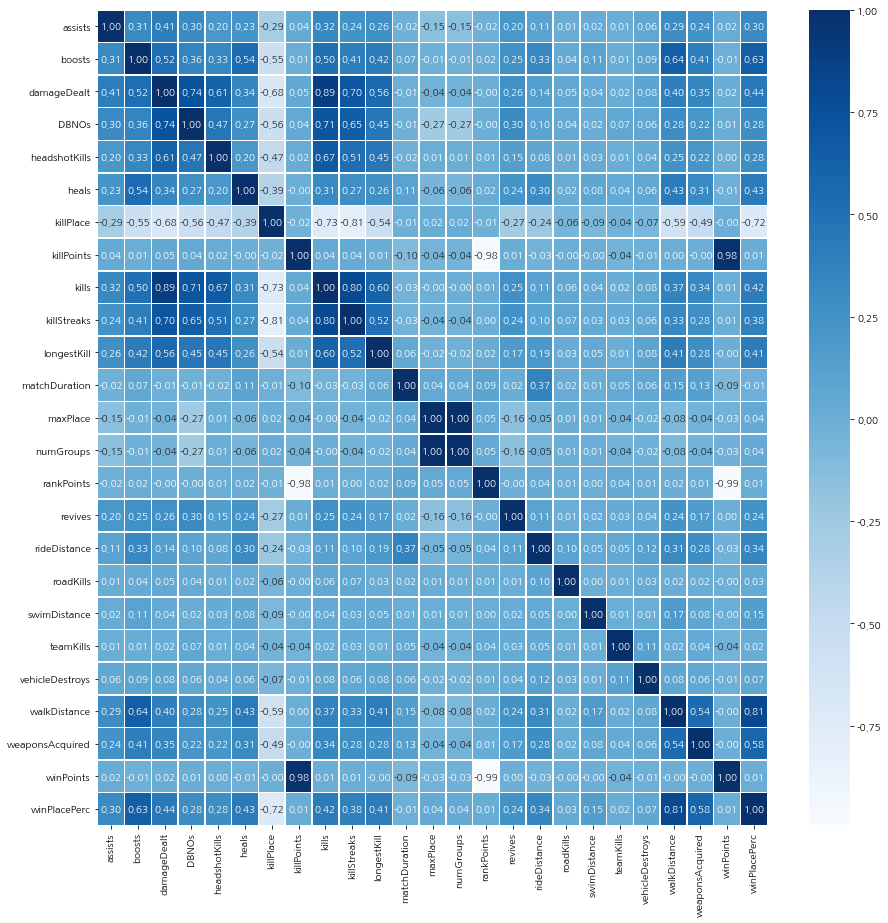

In [45]:
plt.figure(figsize=(15, 15))
sns.heatmap(data=df.corr(), annot=True,
            fmt='.2f', linewidths=.5, cmap='Blues')


- winPlacePerc에 영향을 주는 컬럼
- [DBNOs, assists, boosts, damage Dealt, headshotKills, heals, kills, killStreaks, longestKil,
 revives, rideDistance, swimDistance, walkDistance, weaponsAcquired]
- 그 중에서도 walkDistance, boosts, weaponsAcquired가 높은 것을 확인할 수 있음

In [14]:
# # 시각화 함수
# def plot_counts(p):
#     plt.figure(figsize=(20, 16))
#     sns.countplot(df[p]).set_title(p)
#     plt.show()

### 매치 수

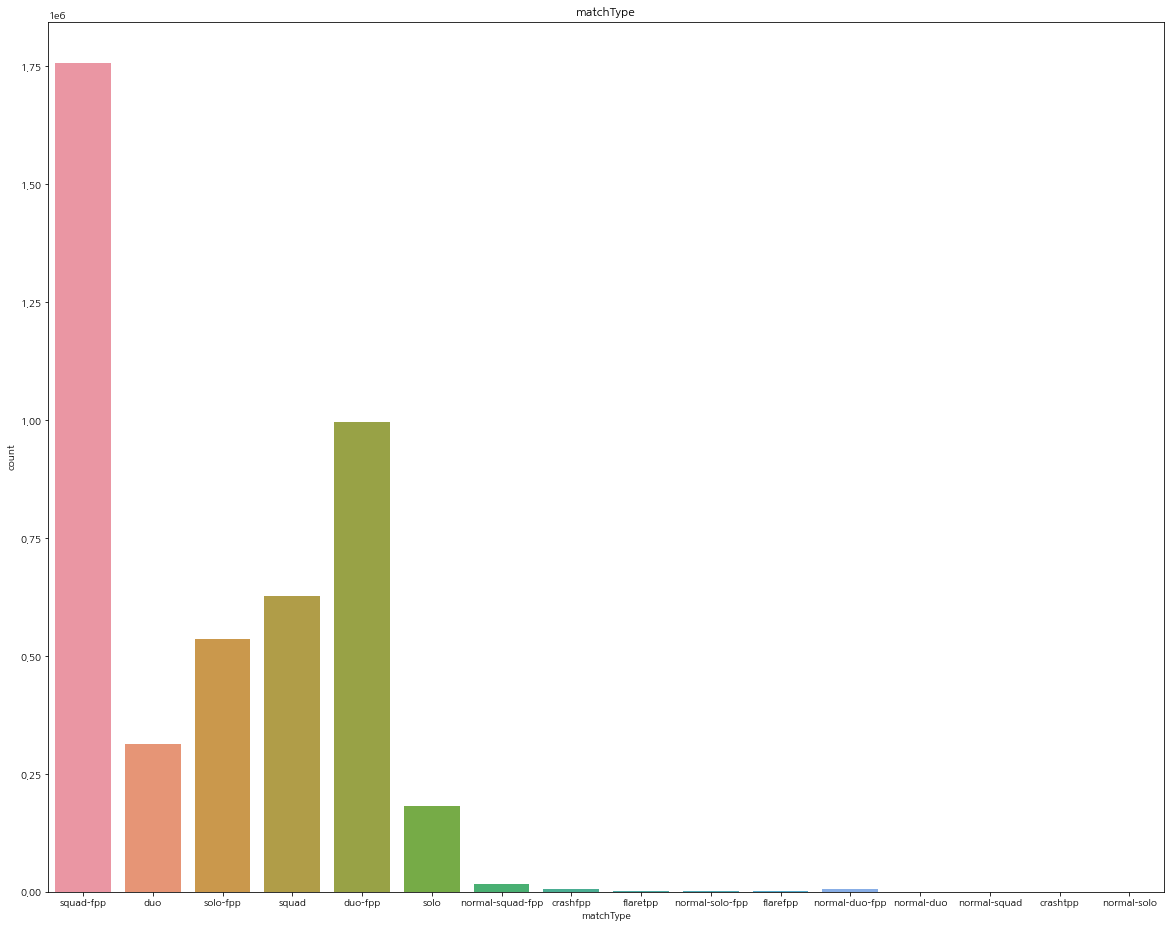

In [19]:
plot_counts('matchType')

In [20]:
df['matchType'].value_counts()

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536761
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

- squad-fpp (스쿼드 1인칭) 모드가 가장 많고, duo-fpp, squad, solo-fpp 모드 순으로 많음
- 외외로 fpp(1인칭 모드)가 많은 것을 볼 수 있음

In [38]:
df.groupby('matchType')['kills'].mean().sort_values(ascending=False)


matchType
normal-solo         7.509202
normal-solo-fpp     7.473841
normal-squad        5.019380
normal-duo          3.829146
normal-squad-fpp    3.122569
normal-duo-fpp      1.956094
solo-fpp            0.934731
duo-fpp             0.926086
squad-fpp           0.908386
duo                 0.907966
squad               0.891428
flarefpp            0.885794
crashtpp            0.881402
solo                0.870932
flaretpp            0.857485
crashfpp            0.779068
Name: kills, dtype: float64

- normal을 제외하면 미세하지만 fpp가 평균 킬 수가 더 많음